### Carga Corpus

In [7]:
! pip3 install -q kaggle


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [8]:
! kaggle datasets download -d arushchillar/disneyland-reviews
! unzip disneyland-reviews.zip

 90%|██████████████████████████████████▏   | 10.0M/11.1M [00:01<00:00, 10.3MB/s]
100%|██████████████████████████████████████| 11.1M/11.1M [00:01<00:00, 6.94MB/s]
Archive:  disneyland-reviews.zip
  inflating: DisneylandReviews.csv   


In [9]:
import pandas as pd

In [80]:
df = pd.read_csv("./DisneylandReviews.csv", encoding="ISO-8859-1")

   Review_ID  Rating Year_Month     Reviewer_Location  \
0  670772142       4     2019-4             Australia   
1  670682799       4     2019-5           Philippines   
2  670623270       4     2019-4  United Arab Emirates   
3  670607911       4     2019-4             Australia   
4  670607296       4     2019-4        United Kingdom   

                                         Review_Text               Branch  
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong  
1  Its been a while since d last time we visit HK...  Disneyland_HongKong  
2  Thanks God it wasn   t too hot or too humid wh...  Disneyland_HongKong  
3  HK Disneyland is a great compact park. Unfortu...  Disneyland_HongKong  
4  the location is not in the city, took around 1...  Disneyland_HongKong  


A fines de generar un modelo de Sentiment Analysis, generaremos una variable Target con el sentimiento de cada review en base a la variable rating de la siguiente manera:
1. Positive: Reseñas con puntaje 4 o 5
2. Neutral: Reseñas con puntaje 3
3. Negative: Reseñas con puntaje 1 y 2

In [89]:
#Genero columna target
def Target(row):
    sentiment = "positive"
    if int(row["Rating"]) == 3:
        sentiment = "neutral"
    elif int(row["Rating"]) < 3:
        sentiment = "negative"
    return sentiment

df["target"] = df.apply(Target, axis=1)
print(df.groupby(['target'])['target'].count())

target
negative     3626
neutral      5109
positive    33921
Name: target, dtype: int64


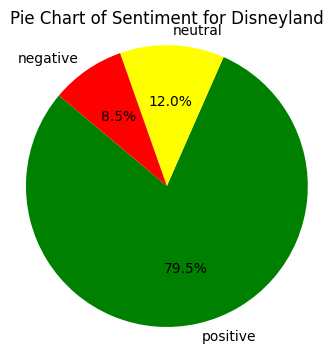

In [91]:
import matplotlib.pyplot as plt


target_counts = df['target'].value_counts()

# Define los colores en un diccionario
colors = {'positive': 'green', 'neutral': 'yellow', 'negative': 'red'}

plt.figure(figsize=(4, 4))
plt.pie(target_counts, labels=target_counts.index, colors=[colors[sentiment] for sentiment in target_counts.index], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Para asegurarte de que el gráfico sea un círculo
plt.title('Pie Chart of Sentiment for Disneyland')
plt.show()

### Vocabulario

Tokenización Bag Of Words: Devuelve frecuencia de aparición de cada palabra en todo el corpus

In [13]:
! pip3 install transformers nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/azulmakk/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
from transformers import AutoTokenizer
from nltk.corpus import stopwords
from collections import defaultdict

import string

stop_words = set(stopwords.words('english'))
tokenizer = AutoTokenizer.from_pretrained("gpt2")

def get_word_freqs(corpus):
    word_freqs = defaultdict(int)

    for text in corpus:
        text = text.translate(str.maketrans('', '', string.punctuation))
        filtered_text = [word.lower() for word in text.split(" ") if word.lower() not in stop_words]
        filtered_text = " ".join(filtered_text)
        words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(filtered_text)
        new_words = [word for word, _ in words_with_offsets]
        for word in new_words:
            word = word.lstrip("Ġ")
            if word != "":
                word_freqs[word] += 1
    
    return word_freqs

[('park', 44309), ('disney', 35973), ('rides', 34295), ('disneyland', 32622), ('time', 29219), ('day', 28145), ('get', 22963), ('go', 20091), ('one', 19081), ('ride', 17661), ('great', 16305), ('would', 14591), ('kids', 14135), ('food', 14129), ('place', 13367)]


In [30]:
corpus = df['Review_Text'].tolist()
word_freqs = get_word_freqs(corpus)
print(sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)[:15])


[('park', 44309), ('disney', 35973), ('rides', 34295), ('disneyland', 32622), ('time', 29219), ('day', 28145), ('get', 22963), ('go', 20091), ('one', 19081), ('ride', 17661), ('great', 16305), ('would', 14591), ('kids', 14135), ('food', 14129), ('place', 13367)]


In [16]:
! pip install wordcloud matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.8/222.8 kB 4.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for wordcloud: filename=wordcloud-1.9.2-cp311-cp311-macosx_13_0_arm64.whl size=153407 sha256=b867291055139954feba4fce2df5abc35084962e23bcf32cbb03631ccd1d6d39
  Stored in directory: /Users/azulmakk/Library/Caches/pip/wheels/3f/c6/5a/89824e1846baaa6d6d54b3a7b1e7deecc9ae6e7ed30a1c8b0e
Successfully built wordcloud

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


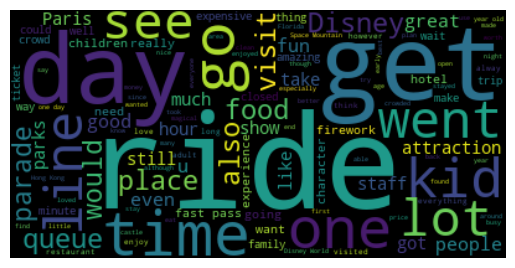

In [53]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(corpus, filtered_words = []):
    filtered_words.extend(stop_words)
    text = "\n".join(corpus)

    wordcloud = WordCloud(stopwords=set(filtered_words)).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plot_word_cloud(corpus)

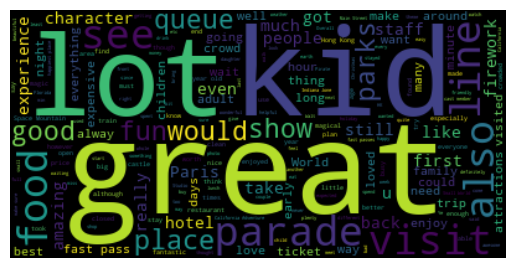

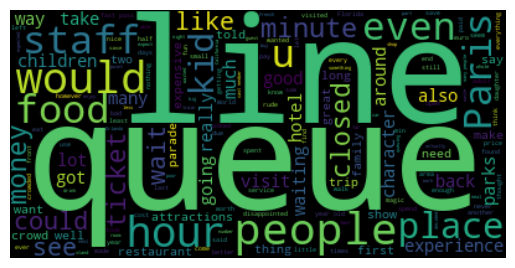

In [63]:
common_words = ["DISNEYLAND", "DISNEY", "RIDE", "RIDES", "PARK", "DAY", "GET", "ATTRACTION", "WENT", "GO", "ONE", "TIME"]
positive_corpus = df[df['target'] == 'positive']['Review_Text'].tolist()
plot_word_cloud(positive_corpus, common_words)

# neutral_corpus = df[df['target'] == 'neutral']['Review_Text'].tolist()
# plot_word_cloud(neutral_corpus, common_words)

negative_corpus = df[df['target'] == 'negative']['Review_Text'].tolist()
plot_word_cloud(negative_corpus, common_words)

/var/folders/22/kk3jgz8n1yn0zwh0vft67d040000gn/T/ipykernel_97896/3122636031.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disneyParis["target"] = df.apply(Target, axis=1)


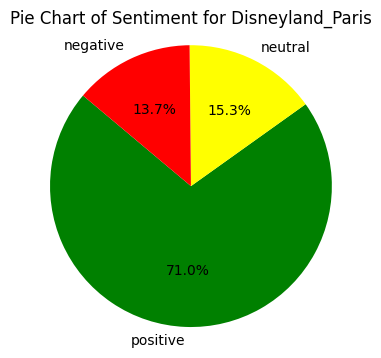

In [84]:
disneyParis = df[df['Branch'] == 'Disneyland_Paris']

disneyParis["target"] = df.apply(Target, axis=1)

target_counts_paris = disneyParis['target'].value_counts()


colors = ['green', 'yellow', 'red']

# Crear el gráfico de torta
plt.figure(figsize=(4, 4))
plt.pie(target_counts_paris, labels=target_counts_paris.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Para asegurarte de que el gráfico sea un círculo
plt.title('Pie Chart of Sentiment for Disneyland_Paris')
plt.show()

/var/folders/22/kk3jgz8n1yn0zwh0vft67d040000gn/T/ipykernel_97896/2503931685.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DisneyHongKong["target"] = df.apply(Target, axis=1)


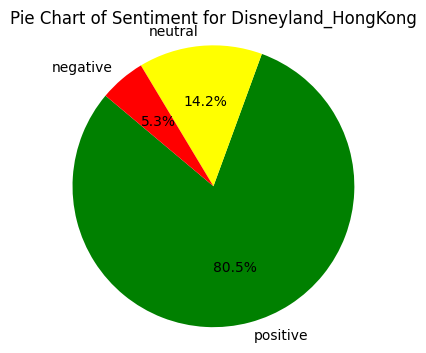

In [97]:
DisneyHongKong = df[df['Branch'] == 'Disneyland_HongKong']

DisneyHongKong["target"] = df.apply(Target, axis=1)

target_counts_hongkong = DisneyHongKong['target'].value_counts()


colors = ['green', 'yellow', 'red']

# Crear el gráfico de torta
plt.figure(figsize=(4, 4))
plt.pie(target_counts_hongkong, labels=target_counts_hongkong.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Para asegurarte de que el gráfico sea un círculo
plt.title('Pie Chart of Sentiment for Disneyland_HongKong')
plt.show()

/var/folders/22/kk3jgz8n1yn0zwh0vft67d040000gn/T/ipykernel_97896/1614667922.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DisneyCalifornia["target"] = df.apply(Target, axis=1)


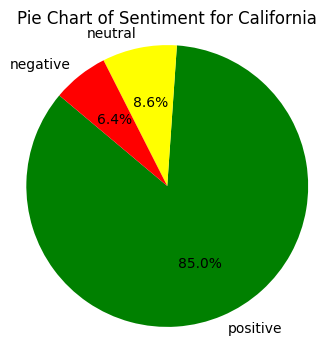

In [99]:
DisneyCalifornia = df[df['Branch'] == 'Disneyland_California']

DisneyCalifornia["target"] = df.apply(Target, axis=1)

target_counts_california = DisneyCalifornia['target'].value_counts()


colors = ['green', 'yellow', 'red']

# Crear el gráfico de torta
plt.figure(figsize=(4, 4))
plt.pie(target_counts_california, labels=target_counts_california.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Para asegurarte de que el gráfico sea un círculo
plt.title('Pie Chart of Sentiment for California')
plt.show()

Byte-Pair Encoding: Amplía el vocabulario con las agrupaciones de tokens más comunes

In [ ]:
DisneyHongKong = df[df['Branch'] == 'Disneyland_Paris']

DisneyHongKong["target"] = df.apply(Target, axis=1)

target_counts_hongkong = DisneyHongKong['target'].value_counts()


colors = ['green', 'yellow', 'red']

# Crear el gráfico de torta
plt.figure(figsize=(4, 4))
plt.pie(target_counts_hongkong, labels=target_counts_hongkong.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Para asegurarte de que el gráfico sea un círculo
plt.title('Pie Chart of Sentiment for Disneyland_HongKong')
plt.show()

In [18]:
vocab = []

for word in word_freqs.keys():
    for letter in word:
        if letter not in vocab:
            vocab.append(letter)
vocab.sort()

print(vocab)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [19]:
#Recibe todos los caracteres separados de las palabras de los documentos, los empareja y calcula la frecuencia de los emparejamientos
def compute_pair_freqs(splits):
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            pair_freqs[pair] += freq
    return pair_freqs

splits = {word: [c for c in word] for word in word_freqs.keys()}
pair_freqs = compute_pair_freqs(splits)

for i, key in enumerate(pair_freqs.keys()):
    print(f"{key}: {pair_freqs[key]}")
    if i >= 5:
        break

('y', 'o'): 16835
('o', 'u'): 130405
('u', 'v'): 1989
('v', 'e'): 125767
('e', 'v'): 54229
('e', 'r'): 231690


In [20]:
#Muestra el par más repetido
best_pair = ""
max_freq = None

for pair, freq in pair_freqs.items():
    if max_freq is None or max_freq < freq:
        best_pair = pair
        max_freq = freq

print(best_pair, max_freq)

('i', 'n') 286933


In [21]:
#encuentra en las palabras los pares indicados y los agrupa
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue

        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

splits = merge_pair("i", "n", splits)

for i, key in enumerate(splits.keys()):
    print(f"{key}: {splits[key]}")
    if i >= 5:
        break

youve: ['y', 'o', 'u', 'v', 'e']
ever: ['e', 'v', 'e', 'r']
disneyland: ['d', 'i', 's', 'n', 'e', 'y', 'l', 'a', 'n', 'd']
anywhere: ['a', 'n', 'y', 'w', 'h', 'e', 'r', 'e']
youll: ['y', 'o', 'u', 'l', 'l']
find: ['f', 'in', 'd']


In [22]:
#muestra los pares más repetidos
merges = {("i", "n"): "in"}
vocab.append("in")

vocab_size = 100 #setea el máximo de pares a insertar hasta que el vocab alcance dicho tamaño

while len(vocab) < vocab_size:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])

print(merges)

{('i', 'n'): 'in', ('e', 'r'): 'er', ('a', 'r'): 'ar', ('e', 's'): 'es', ('e', 'n'): 'en', ('a', 'n'): 'an', ('o', 'n'): 'on', ('e', 'd'): 'ed', ('s', 't'): 'st', ('in', 'g'): 'ing', ('i', 's'): 'is', ('a', 'l'): 'al', ('o', 'u'): 'ou', ('r', 'e'): 're', ('r', 'i'): 'ri', ('t', 'i'): 'ti', ('t', 'h'): 'th', ('n', 'e'): 'ne', ('p', 'ar'): 'par', ('o', 'r'): 'or', ('a', 'y'): 'ay', ('l', 'y'): 'ly', ('l', 'e'): 'le', ('a', 't'): 'at', ('i', 't'): 'it', ('d', 'is'): 'dis', ('a', 'c'): 'ac', ('c', 'h'): 'ch', ('m', 'e'): 'me', ('ne', 'y'): 'ney', ('dis', 'ney'): 'disney', ('e', 't'): 'et', ('l', 'o'): 'lo', ('l', 'd'): 'ld', ('ri', 'd'): 'rid', ('an', 'd'): 'and', ('par', 'k'): 'park', ('a', 's'): 'as', ('i', 'c'): 'ic', ('en', 't'): 'ent', ('h', 'o'): 'ho', ('a', 'd'): 'ad', ('g', 'o'): 'go', ('s', 'e'): 'se', ('i', 'd'): 'id', ('g', 'h'): 'gh', ('v', 'er'): 'ver', ('e', 'l'): 'el', ('l', 'and'): 'land', ('r', 'o'): 'ro', ('d', 'ay'): 'day', ('a', 'st'): 'ast', ('m', 'a'): 'ma', ('k', 'e'

In [23]:
print(vocab)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'in', 'er', 'ar', 'es', 'en', 'an', 'on', 'ed', 'st', 'ing', 'is', 'al', 'ou', 're', 'ri', 'ti', 'th', 'ne', 'par', 'or', 'ay', 'ly', 'le', 'at', 'it', 'dis', 'ac', 'ch', 'me', 'ney', 'disney', 'et', 'lo', 'ld', 'rid', 'and', 'park', 'as', 'ic', 'ent', 'ho', 'ad', 'go', 'se', 'id', 'gh', 'ver', 'el', 'land', 'ro', 'day', 'ast', 'ma', 'ke', 'ex', 'co', 'un', 've', 'ta', 'li', 'one', 'rides', 'od', 'pl']


TF-IDF: Devuelve el "peso" de cada palabra dentro de cada documento

In [24]:
#Genera peso para cada palabra de cada documento
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(ngram_range=(1,1))
bow = vect.fit_transform(df['Review_Text'])
total_features = len(vect.vocabulary_)

print(bow[0]) #muestro pesos de palabras del documento 0

  (0, 41364)	0.1001492200981683
  (0, 25160)	0.20600502154289962
  (0, 30266)	0.11275120859486311
  (0, 7019)	0.05829991283947452
  (0, 7016)	0.12341899729910027
  (0, 31274)	0.2110461653694468
  (0, 19448)	0.14296940427420587
  (0, 15187)	0.40736440254022876
  (0, 41105)	0.054389236206943546
  (0, 40703)	0.11483688974099217
  (0, 41239)	0.055650551288347685
  (0, 10944)	0.06946702845806878
  (0, 12625)	0.16545266576934287
  (0, 42058)	0.10604310854674263
  (0, 3628)	0.08094545381697389
  (0, 15102)	0.18579588362807836
  (0, 2379)	0.1519902393440763
  (0, 21036)	0.05185857855824448
  (0, 42003)	0.10350991944390095
  (0, 34545)	0.10738379562638303
  (0, 21148)	0.11812076028098253
  (0, 32059)	0.06138379785868412
  (0, 26305)	0.04897450110208785
  (0, 26485)	0.07978823375016844
  (0, 15630)	0.1322952178630234
  (0, 15239)	0.2325311041202991
  (0, 18567)	0.10825934671193119
  (0, 21084)	0.048242108888394274
  (0, 36109)	0.1384200746449041
  (0, 23353)	0.12386423798982706
  (0, 20868)	0.12

In [25]:
#muestro orden de palabras con mayor peso del documento 0
print(sorted((bow[0,doc] for doc in range(total_features)), reverse=True))

[0.40736440254022876, 0.2325311041202991, 0.22969747696709086, 0.2110461653694468, 0.20600502154289962, 0.18579588362807836, 0.18484489677369395, 0.1792384341959779, 0.1775177835729147, 0.16545266576934287, 0.15805119886448088, 0.1536947280067274, 0.1519902393440763, 0.14955283785427426, 0.14296940427420587, 0.13934608759406988, 0.1384200746449041, 0.13734265011283436, 0.13734265011283436, 0.1322952178630234, 0.13087309645573716, 0.1305592968997868, 0.12973968688092583, 0.1258642322562421, 0.12386423798982706, 0.12341899729910027, 0.12094095334318135, 0.11812076028098253, 0.11483688974099217, 0.11275120859486311, 0.10825934671193119, 0.10738379562638303, 0.10604310854674263, 0.10350991944390095, 0.1001492200981683, 0.09246830314652003, 0.08897272401561206, 0.08094545381697389, 0.07978823375016844, 0.07673289553322223, 0.06946702845806878, 0.06138379785868412, 0.05829991283947452, 0.055650551288347685, 0.054389236206943546, 0.05185857855824448, 0.05094929285362996, 0.04897450110208785, 

In [26]:
print(bow[0]==0.40736440254022876) #la palabra con el mayor peso del doc 0 es la 15187

  (0, 15187)	True


In [27]:
vect.get_feature_names_out()[15187]

'fairly'

In [28]:
df["Review_Text"][0]

"If you've ever been to Disneyland anywhere you'll find Disneyland Hong Kong very similar in the layout when you walk into main street! It has a very familiar feel. One of the rides  its a Small World  is absolutely fabulous and worth doing. The day we visited was fairly hot and relatively busy but the queues moved fairly well. "

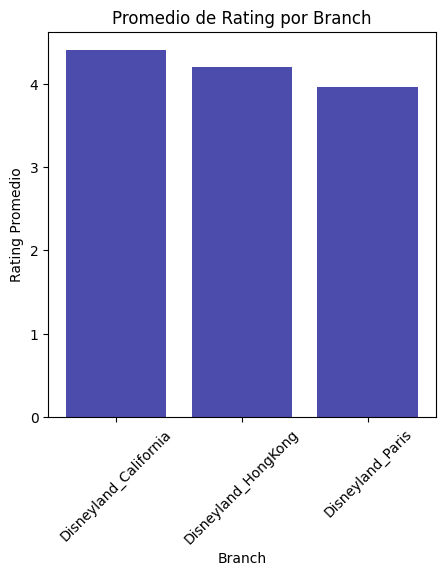

In [100]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame llamado df con columnas 'Branch' y 'Rating'

# Agrupar por 'Branch' y calcular el promedio del 'Rating' en cada grupo
branch_ratings_avg = df.groupby('Branch')['Rating'].mean()

# Obtener las etiquetas de las sucursales
branch_labels = branch_ratings_avg.index

# Obtener los valores promedio de Rating
ratings_avg_values = branch_ratings_avg.values

# Crear un gráfico de barras
plt.figure(figsize=(5, 5))
plt.bar(branch_labels, ratings_avg_values, color='darkblue', alpha=0.7)
plt.xlabel('Branch')
plt.ylabel('Rating Promedio')
plt.title('Promedio de Rating por Branch')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para una mejor visualización
plt.show()
